In [1]:
import os
import sys

# --- Path setup ---
# Get current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

# Assume this file is in /home/jiangwolin/rl4co/examples
# Add project root (/home/jiangwolin/rl4co) to sys.path
project_root = os.path.abspath(os.path.join(cwd, "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root added to sys.path:", project_root)

# --- Autoreload setup ---
%load_ext autoreload
%autoreload 2

# --- Imports ---
from rl4co.envs.routing import PDPTWEnv, PDPTWGenerator
from rl4co.models.zoo import AttentionModel
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.models.rl import PPO
from ortools_solver import darp_solver

Current working directory: /Users/jiangwolin/Downloads/llm-darp-main/rl4co/examples
Project root added to sys.path: /Users/jiangwolin/Downloads/llm-darp-main


In [5]:
import torch
from rl4co.models.zoo import AttentionModelPolicy
from rl4co.envs.routing import PDPTWEnv

env = PDPTWEnv()

# Load checkpoint

env.reset(batch_size=[1])

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([1, 61]), device=cpu, dtype=torch.bool, is_shared=False),
        capacity: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        current_node: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        current_time: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        demand: Tensor(shape=torch.Size([1, 61]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        flexibility: Tensor(shape=torch.Size([1, 61]), device=cpu, dtype=torch.float32, is_shared=False),
        h3_indices: Tensor(shape=torch.Size([1, 61]), device=cpu, dtype=torch.int64, is_shared=False),
        i: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        locs: Tensor(shape=torch.Size([1, 61, 2]), device=cpu, dt

In [37]:
model = REINFORCE.load_from_checkpoint("/Users/jiangwolin/Downloads/llm-darp-main/checkpoints/sf_newenv_3/epoch_epoch=062.ckpt", env=env)

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.6, which is newer than your current Lightning version: v2.5.5
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['baseline.baseline.policy.encoder.init_embedding.project.weight', 'baseline.baseline.policy.encoder.init_e

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [39]:
trained_policy = model.policy

In [45]:
trained_out = trained_policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
trained_out

{'reward': tensor([-3157.1499]),
 'log_likelihood': tensor([-23.0532], grad_fn=<SumBackward1>),
 'actions': tensor([[51, 25, 52, 26, 15, 16,  0, 31, 53,  9, 41, 10,  3,  4,  0, 54, 19, 20,
          11, 27, 45, 47, 59, 12, 48, 60, 55, 56,  0, 28, 49, 50,  0, 37, 32,  0,
          43, 21, 44, 22, 46,  0, 38, 13, 23, 33, 39, 57,  7, 29, 35,  1,  8, 36,
           2, 17, 18,  0, 42, 14, 58,  5, 30,  6,  0, 40, 24,  0, 34,  0]])}

In [33]:
# Initiate untrained policy
untrained_policy = AttentionModelPolicy(env_name=env.name,
                                        embed_dim = 128,
                                        num_encoder_layers=3,
                                        num_heads=8)

{'reward': tensor([-3157.1499]), 'log_likelihood': tensor([-23.0532], grad_fn=<SumBackward1>), 'actions': tensor([[51, 25, 52, 26, 15, 16,  0, 31, 53,  9, 41, 10,  3,  4,  0, 54, 19, 20,
         11, 27, 45, 47, 59, 12, 48, 60, 55, 56,  0, 28, 49, 50,  0, 37, 32,  0,
         43, 21, 44, 22, 46,  0, 38, 13, 23, 33, 39, 57,  7, 29, 35,  1,  8, 36,
          2, 17, 18,  0, 42, 14, 58,  5, 30,  6,  0, 40, 24,  0, 34,  0]])}
{'reward': tensor([-2470.1167]), 'log_likelihood': tensor([-77.6785], grad_fn=<SumBackward1>), 'actions': tensor([[55,  3,  4,  0, 15, 16,  0,  5, 19,  6,  0, 51, 52,  0, 11, 27, 12,  0,
         25, 26,  0, 45, 49, 46,  0, 50,  0, 56,  0, 47, 48,  0, 28,  0, 35,  7,
         36,  8,  0, 59, 60,  0, 17, 18,  0, 41, 42,  0, 37,  9, 38,  0, 20,  0,
         13, 57, 29, 14,  0, 30,  0, 21, 22,  0,  1,  2,  0, 58,  0, 43, 44,  0,
         10,  0, 23, 24,  0, 33, 34,  0, 39, 40,  0, 53, 54,  0, 31, 32,  0]])}


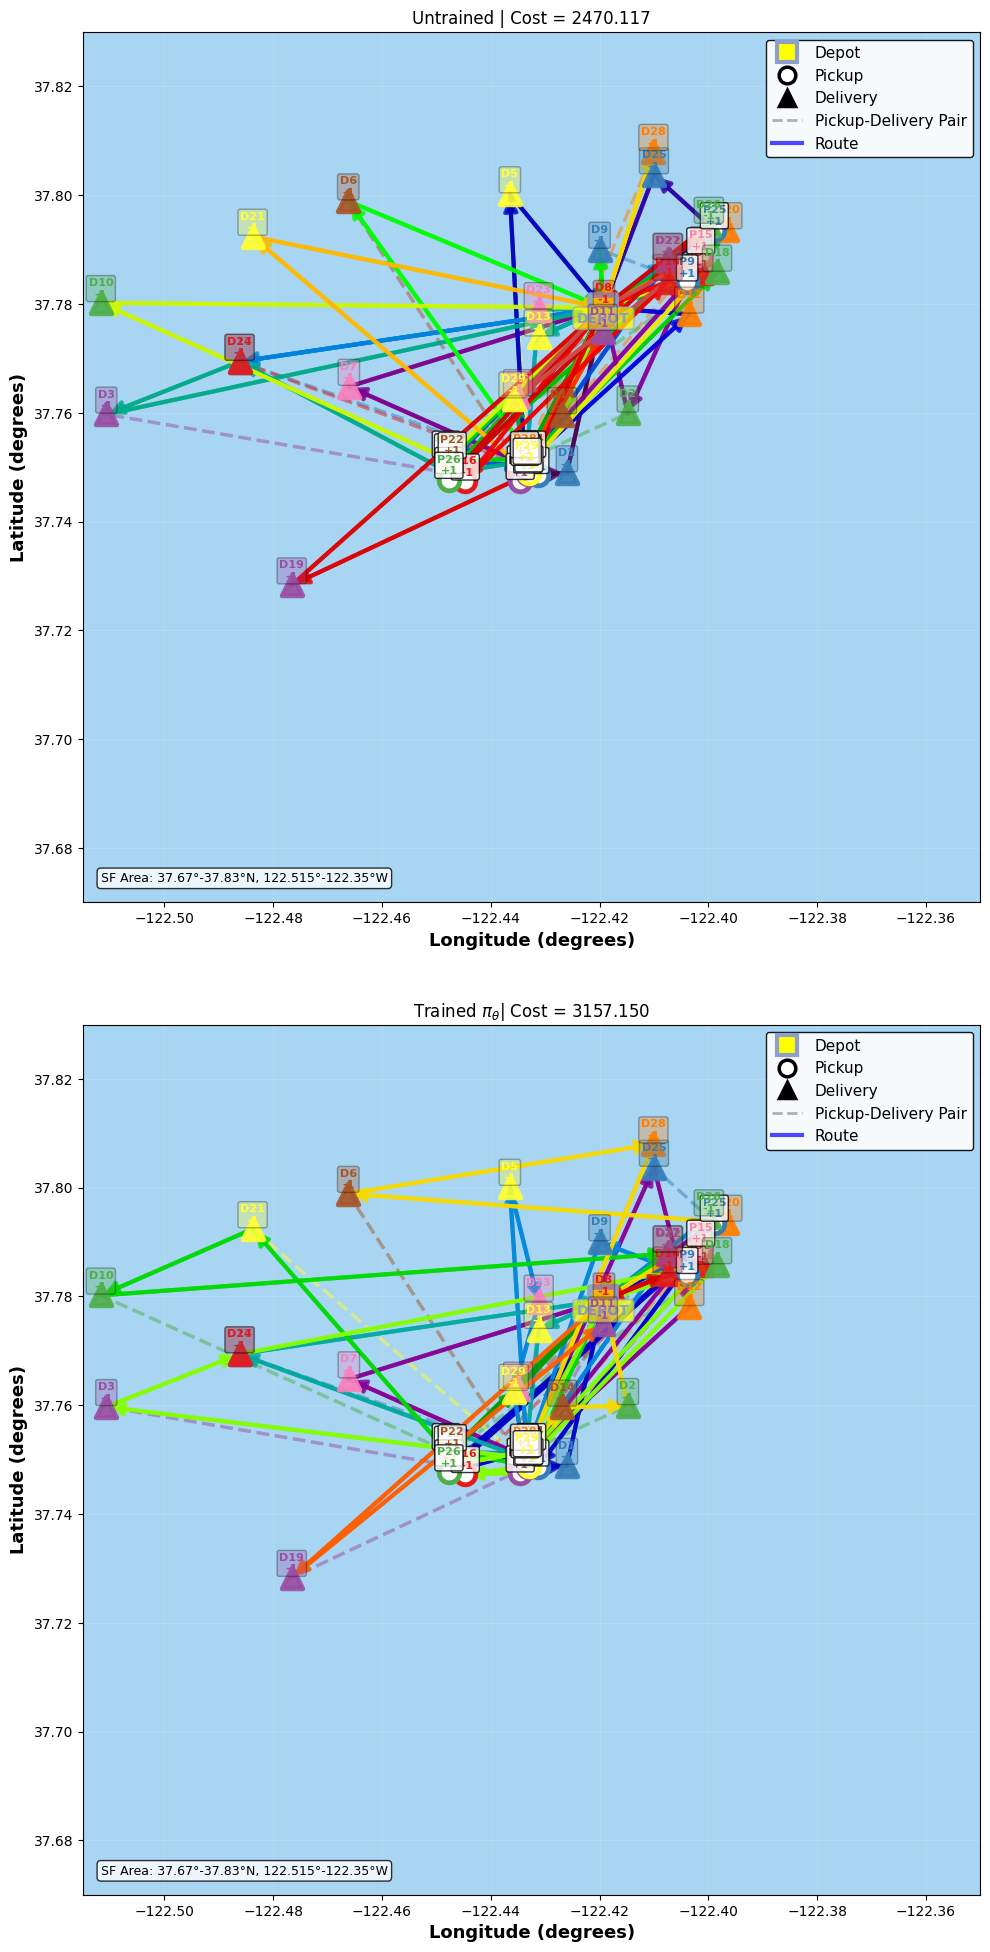

In [35]:
device = 'cpu'

td_init = PDPTWEnv(generator_params={"num_customers":30}).reset(batch_size=[1]).to(device)

#trained_policy = model_checkpoint.policy.to(device)

trained_out = trained_policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
untrained_out = untrained_policy(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)

actions_trained = trained_out['actions'].cpu().detach()
actions_untrained = untrained_out["actions"].cpu().detach()

rewards_trained = trained_out['reward']
rewards_untrained = untrained_out['reward']

import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(2,1, figsize=(11,20))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-rewards_trained[i].item():.3f}")

print(trained_out)
print(untrained_out)

In [22]:
device = 'cpu'

td_init = PDPTWEnv(generator_params={"num_customers":30}).reset(batch_size=[1]).to(device)

trained_policy = model_checkpoint.policy.to(device)

trained_out = trained_policy(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)
untrained_out = untrained_policy(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)
trained_out

{'reward': tensor([-3426.4165]),
 'log_likelihood': tensor([-25.8018], grad_fn=<SumBackward1>),
 'actions': tensor([[ 7, 53, 45, 37, 11, 41,  8, 38, 54, 12, 49, 50, 39, 43,  5, 47,  6, 48,
           0, 46, 40, 44,  0, 33, 13, 21, 17, 23, 51, 14, 35, 29, 31, 30, 59, 32,
          57, 60,  0, 34, 25, 15, 24, 16,  3, 19,  4,  9, 27, 10, 28,  0, 42, 18,
          22, 20, 58,  0, 52, 55, 26,  0, 56, 36,  1,  2,  0]])}

In [28]:
from tqdm import tqdm

records = {}

for i in tqdm(range(25, 26, 5)):
    or_tools = []
    neural = []

    for j in tqdm(range(3)):  # Each instance run for j times
        td_init = PDPTWEnv(generator_params={"num_customers": i}).reset(batch_size=[1]).to(device)

        neural_out = trained_policy(
            td_init.clone(),
            phase="test",
            decode_type="greedy",
            return_actions=True,
        )
        print(neural_out)
        or_out = darp_solver(td_init, time_limit_seconds=1)

        # be careful: neural_out["reward"] is probably a tensor → convert to scalar if needed
        neural.append((- neural_out["reward"]).detach().cpu().item())
        or_tools.append(or_out["total_time"])

    # create the entry for this i
    records[f"{i} req"] = {
        "or_tools": or_tools,
        "neural": neural,
    }

  0%|                                                     | 0/3 [00:00<?, ?it/s]

{'reward': tensor([-1626.7666]), 'log_likelihood': tensor([-9.3254], grad_fn=<SumBackward1>), 'actions': tensor([[11, 35, 12, 36, 49, 50,  9, 43, 10, 15, 33, 16, 44, 27, 31, 28, 47, 34,
         32, 37, 38,  0, 25,  1, 26,  2, 19, 39, 17, 13,  3,  4, 29, 30,  5, 21,
          6, 22, 41, 48, 42,  0, 40,  7, 20,  0,  8, 18, 14, 45, 46,  0, 23, 24,
          0]])}



 33%|███████████████                              | 1/3 [00:01<00:02,  1.18s/it]

{'reward': tensor([-1832.9000]), 'log_likelihood': tensor([-7.2718], grad_fn=<SumBackward1>), 'actions': tensor([[39, 29, 25, 33, 49, 11, 12, 35, 45,  3, 36,  4, 21, 31, 32, 47, 22,  7,
          8, 37, 38,  5,  6, 19, 20,  0, 40, 30, 34, 43, 26, 44,  9, 23, 24, 10,
          0, 50, 46, 27, 17, 28, 41, 42, 18, 48, 13, 14,  0,  1,  2, 15, 16,  0]])}



 67%|██████████████████████████████               | 2/3 [00:02<00:01,  1.17s/it]

{'reward': tensor([-1230.4667]), 'log_likelihood': tensor([-8.0029], grad_fn=<SumBackward1>), 'actions': tensor([[ 5, 23,  6, 24,  1, 39, 47, 27,  2, 48, 35, 28, 36, 41,  3, 17, 45, 42,
         15,  4, 18, 46, 11, 12, 37, 13, 33, 38, 14, 34,  0, 19, 21, 20, 25, 29,
         26, 30, 40, 49,  9,  7, 50, 10,  8,  0, 22, 43, 44, 31, 32,  0, 16,  0]])}



100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/it]


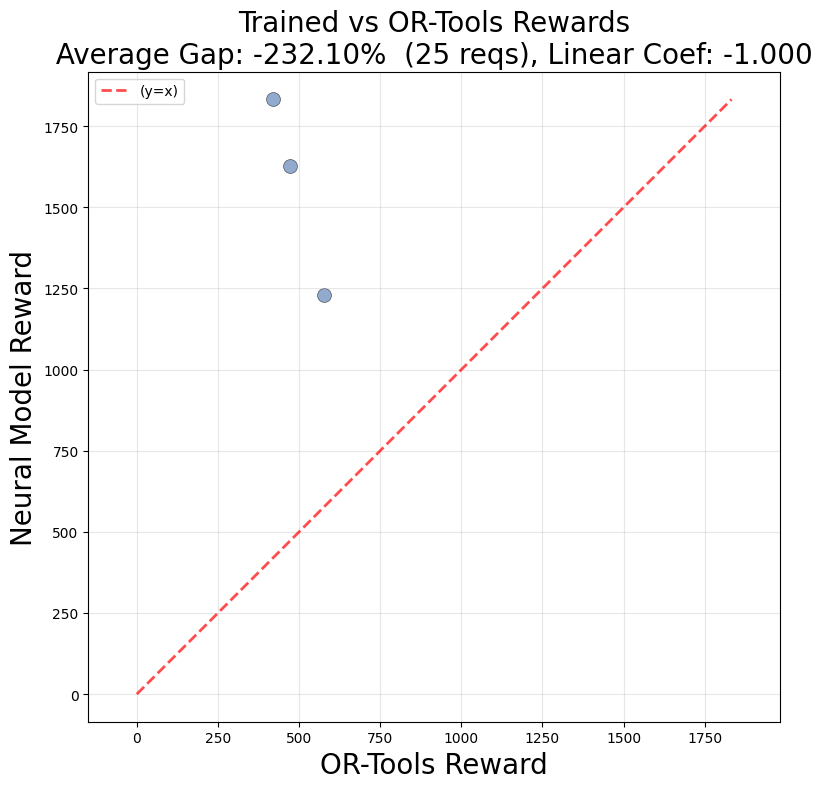

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
reqs = 25

# Prepare data
trained_rewards = np.array(records[f"{reqs} req"]["neural"])
or_rewards = np.array(records[f"{reqs} req"]["or_tools"])


# ---- Filter out -inf values ----
mask = (trained_rewards != -np.inf) & (or_rewards != -np.inf)
trained_rewards = trained_rewards[mask]
or_rewards = or_rewards[mask]
# --------------------------------

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(
    or_rewards,
    trained_rewards,
    alpha=0.6,
    s=100,
    color='#4c72b0',
    edgecolors='black',
    linewidth=0.5
)

# Add diagonal reference line
min_val = min(or_rewards.min(), trained_rewards.min())
max_val = max(or_rewards.max(), trained_rewards.max())
plt.plot(
    [0, max_val],
    [0, max_val],
    'r--',
    linewidth=2,
    label='(y=x)',
    alpha=0.7
)

# Labels and title
plt.xlabel("OR-Tools Reward", fontsize=20)
plt.ylabel("Neural Model Reward", fontsize=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Mean optimality gap (only for valid points)
gap = np.mean((or_rewards - trained_rewards) / np.abs(or_rewards)) * 100
slope, intercept, r_value, p_value, std_err = stats.linregress(or_rewards, trained_rewards)
plt.title(f"Trained vs OR-Tools Rewards\n Average Gap: {gap:.2f}%  ({reqs} reqs), Linear Coef: {r_value:.3f} ",fontsize=20)

plt.tight_layout()
plt.show()

In [226]:
def check_pairwise_validity(seq: torch.Tensor) -> bool:
    """
    Check if every subroute (separated by 0) contains only valid (2i-1, 2i) pairs.
    A pair is valid if for every request i, either both nodes (2i-1 and 2i)
    appear together in the same slice or neither appears at all.
    """
    # Convert tensor to list
    arr = seq.tolist()
    # Split by 0
    slices = []
    cur = []
    for x in arr:
        if x == 0:
            if cur:
                slices.append(cur)
                cur = []
        else:
            cur.append(x)
    if cur:
        slices.append(cur)

    # Check each slice
    for s in slices:
        s_set = set(s)
        for i in range(1, (max(s) // 2) + 2):
            a, b = 2 * i - 1, 2 * i
            in_a, in_b = a in s_set, b in s_set
            if in_a ^ in_b:  # only one of them is present
                return False
    return True

check_pairwise_validity(actions_trained[0])

False

/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:186: RuntimeWarning: vehicle cannot perform service and get back to depot in time.
  warnings.warn(
/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


FalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalse

/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrp/env.py:191: RuntimeWarning: Used more than capacity
  warnings.warn("Used more than capacity", RuntimeWarning)


FalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalse

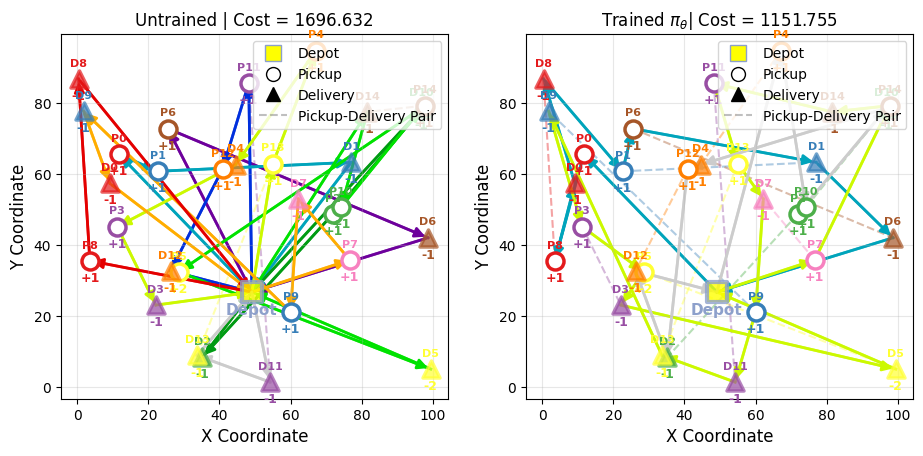

In [227]:
# Compare policy with untrained policy
check = False
while check == False: 
      
  # Testing: Greedy rollouts over trained model (same states as previous plot)
  env = PDPTWEnv(generator_params={"num_loc":30})
  td_init = env.reset(batch_size=[1]).to(device)

  out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
  actions_trained = out['actions'].cpu().detach()
  rewards_trained = out['reward']
  check = check_pairwise_validity(actions_trained[0])
  print(check, end='')
  

untrained_policy = AttentionModelPolicy(env_name=env.name, 
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8
                            )

untrained_out = untrained_policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = untrained_out['actions'].cpu().detach()
rewards_untrained = untrained_out['reward']



# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

print(actions_trained)
